In [3]:
library(tidyverse)
ggplot2::theme_set(theme_bw())
library(showtext)
setwd("C:/Users/이찬솔/Documents/ADP/problem/problem5")

In [2]:
font_add_google(name = "Black Han Sans", family = "blackhansans")
showtext_auto()

# 문제 1

#### dataset : pima-indians-diabetes-database [kaggle link](pima-indians-diabetes-database) - added post-processing
/kaggle/input/adpkrp5/data1.csv

In [4]:
data1 <- read.csv("data1.csv")

In [10]:
colSums(is.na(data1))

Pregnancies                  Glucose            BloodPressure 
                       0                        0                        0 
           SkinThickness                  Insulin                      BMI 
                       0                        0                        0 
DiabetesPedigreeFunction                      Age                  Outcome 
                       0                        0                        0

### 1-1 탐색적 데이터 분석 수행(시각화 포함)

In [7]:
# summary(data1)
# map(data1, sd)

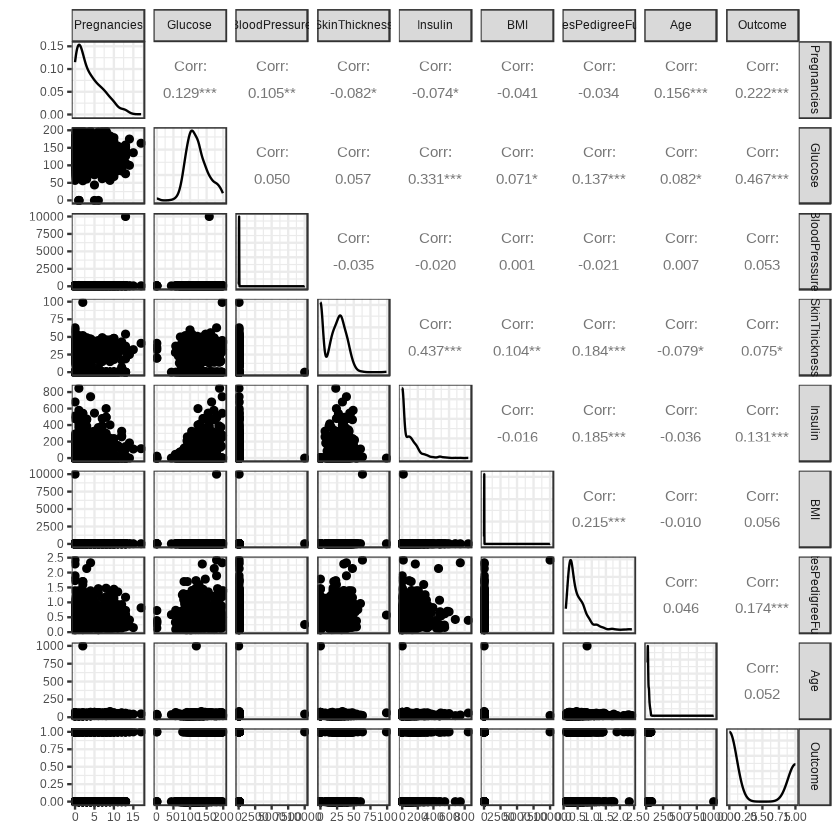

In [9]:
library(GGally)
ggpairs(data1)

### 1-2 이상치 처리(이상값 대체방안 제시)

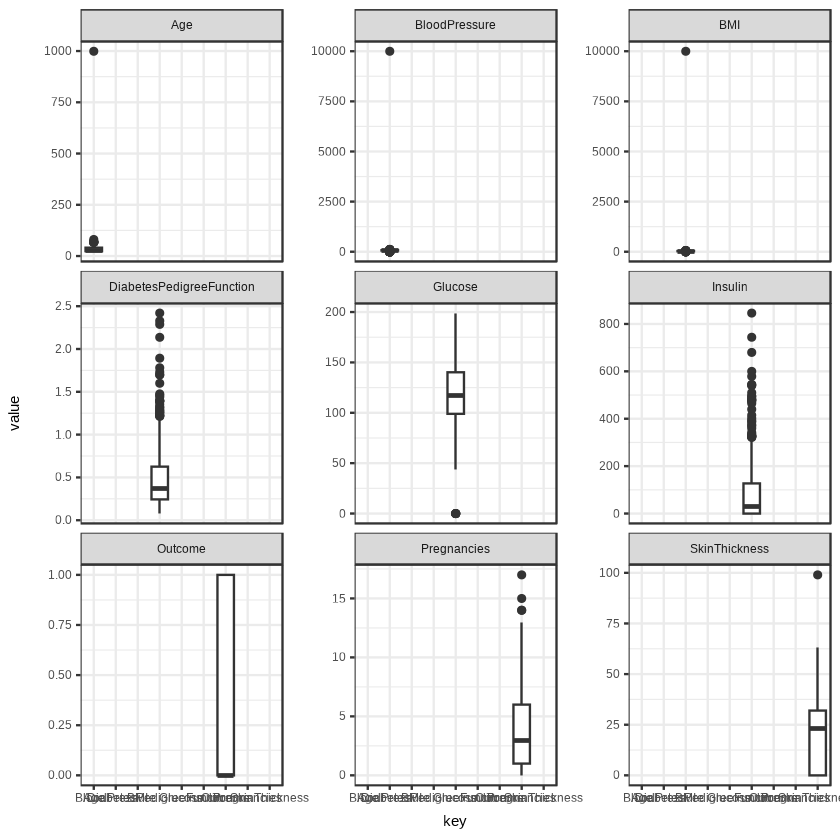

In [13]:
gather(data1) %>% group_by(key) %>% 
    ggplot(aes(key, value, group = key)) + geom_boxplot() + 
    facet_wrap(~ key, scales = "free_y")

- Age, BloodPressure, BMI에서 이창시값들이 확인, 3개 미만의 이상치들이므로 해당값들을 최댓값으로 대체

In [23]:
data1 %>% select(Age) %>% arrange(Age) %>% tail %>% unlist
data1 %>% select(BloodPressure) %>% arrange(BloodPressure) %>% tail %>% unlist
data1 %>% select(BMI) %>% arrange(BMI) %>% tail %>% unlist

Age1 Age2 Age3 Age4 Age5 Age6 
  68   69   69   70   81  999

BloodPressure1 BloodPressure2 BloodPressure3 BloodPressure4 BloodPressure5 
           108            110            110            110            122 
BloodPressure6 
          9999

BMI1   BMI2   BMI3   BMI4   BMI5   BMI6 
  52.9   53.2   55.0   57.3   67.1 9999.0

In [32]:
data12 <- data1 %>%
    mutate(Age = ifelse(Age == max(Age), 81, Age),
           BloodPressure = ifelse(BloodPressure == max(BloodPressure), 122, BloodPressure),
           BMI = ifelse(BMI == max(BMI), 67.1, BMI))

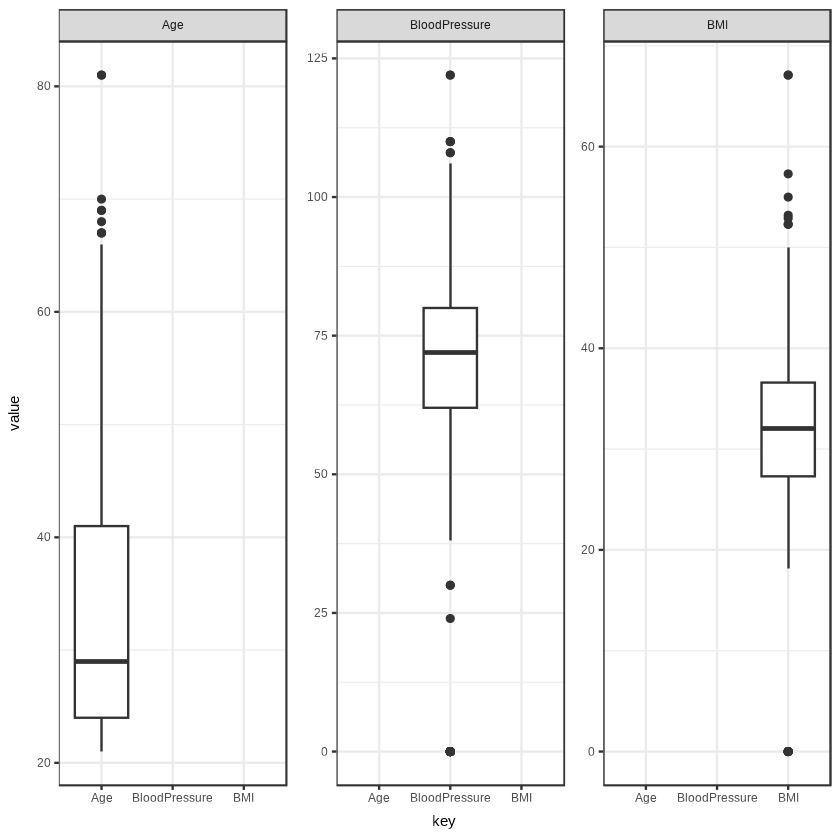

In [37]:
data12 %>% select(Age, BloodPressure, BMI) %>% gather() %>%
    group_by(key) %>% ggplot(aes(key, value, group = key)) + geom_boxplot() + 
    facet_wrap(~ key, scales = "free_y")

### 1-3 앞선 두 단계에서 얻은 향후 분석시 고려사항 작성

In [46]:
data13 <- data12 %>%
    mutate(Outcome = as.factor(Outcome))
data13 %>% group_by(Outcome) %>% count()

Outcome,n
<fct>,<int>
0,500
1,268


- 반응변수 Outcome에 데이터의 불균형이 존재
- 따라서 이를 보완하기 위한 오버/언더 샘플링이 필요

# 문제 2

### 2-1 오버샘플링 과정 설명하고 결과 작성

- 오버 샘플링 : 소수 클래스의 데이터를 복제 또는 생성하여 데이터의 비율을 맞추는 방법

장점
- 정보가 손실되지 않음
- 알고리즘의 성능이 언더샘플링에 비해 증가

단점
- 데이터 증가로 인한 계산시간의 증가
- 과적합을 초래하여, 검증의 성능이 감소할 가능성 존재

랜덤 과대표집 (ROS)

- 무작위로 소수 클래스 데이터를 복제하여 데이터의 비율을 맞추는 간단한 방법이지만, 데이터의 중복으로 인하여 과적합 문제 발생 가능성이 증가


In [53]:
library(caret)

In [59]:
UpSamp <- caret::upSample(data13 %>% select(-Outcome),
                          data13$Outcome) %>%
    mutate(Outcome = as.factor(Class)) %>% select(-Class)

In [60]:
UpSamp %>% group_by(Outcome) %>% count()

Outcome,n
<fct>,<int>
0,500
1,500


SMOTE (Synthetic Minority Oversampling Technique)
- 소수 클래스에서 중심이 되는 데이터와 주변 데이터 사이에 가상의 직선을 만든 후, 그 위에 데이터를 추가하는 방법
- 랜덤 과대표집과 달리 중복을 사용하는 알고리즘이 아님 => ROS에 비해 과적합 문제 발생 가능성이 낮음, 하지만 마찬가지로 과적합 가능성 존재

In [64]:
library(smotefamily)

In [77]:
Smote <- SMOTE(data13 %>% select(-Outcome),
               data13$Outcome, dup_size = 1)

In [78]:
Smote <- Smote$data %>% mutate(Outcome = as.factor(class)) %>% select(-class) 

In [79]:
Smote %>% group_by(Outcome) %>% count()

Outcome,n
<fct>,<int>
0,500
1,536


### 2-2 언더샘플링 과정 설명하고 결과 작성

언더 샢를링 (과소표집)
- 다수 클래스의 데이터를 일부만 선택하여 데이터의 비율을 맞추는 방법
- 과소 표집의 경우 데이터의 소실이 매우 크고, 때로는 중요한 정상 데이터를 잃을 수 있다.

토멕 링크 방법 (Tomek Link Method)
- 토멕 링크는 클래스를 구분하는 경계선 가까이에 존재하는 데이터이다.
- 토멕 링크 방법은 다수 클래스에 속한 토멕 링크를 제거하는 방법

In [83]:
library(unbalanced)

In [91]:
Tomek <- ubTomek(data13 %>% select(-Outcome),
               data13$Outcome, verbose = F)

In [92]:
Tomek <- Tomek$X %>% mutate(Outcome = as.factor(Tomek$Y))
Tomek %>% group_by(Outcome) %>% count()

Outcome,n
<fct>,<int>
0,395
1,268


CNN (Condensed Nearest Neighbor)
- CNN은 다수 클래스에 밀집된 데이터가 없을 떄 까지 데이터를 제거하여 데이터 분포에서 대표적인 데이터만 남도록 하는 방법

In [96]:
OSS <- ubOSS(data13 %>% select(-Outcome),
               data13$Outcome, verbose = F)

In [97]:
OSS <- OSS$X %>% mutate(Outcome = as.factor(OSS$Y))
OSS %>% group_by(Outcome) %>% count()

Outcome,n
<fct>,<int>
0,394
1,268


### 2-3 둘 중 선택하고 이유 설명

- 오버샘플링 선택
- 과적합의 가능성이 있지만, 학습데이터의 증가로 인하여 알고리즘의 성능이 증가할 수도 있음

# 문제 3

### 3-1 최소 3개 이상 알고리즘 제시하고 정확도 측면의 모델 1개와 속도 측면의 모델 1개를 꼭 구현(총 2개 이상)

1. 로지스틱 회귀분석 : 반응변수의 각 범주에 속할 확률이 얼마인지를 추정하여, 추정확률을 기준치에 따라 분류하는 목적으로 사용되는 분류 분석 모형
2. SVM : 데이터를 분리하는 초평면 중에서 데이터들과 거리가 가장 먼 초평면을 선택하여 분리하는 분류 분석 모형
3. 랜덤포레스트 : 의사결정나무의 특징인 분산을 크다는 점을 고려하여 배깅과 부스팅보다 더 많은 무작위성을 주어, 약한 학습기들을 생성한 후 이를 선형 결합하여 최종 학습기를 만드는 분석 모형

속도 측면 : 로지스틱 회귀 
- 하이퍼 파라미터 탐색 없음 => 속도 향상

In [216]:
set.seed(1234)
train <- sample(1:nrow(Smote), round(0.7 * nrow(Smote)))
test <- setdiff(1:nrow(Smote), train)

In [285]:
start <- Sys.time()
mod1 <- caret::train(
    Outcome ~ .,
    data = Smote[train, ],
    method = "glm",
    family = "binomial"
)
end <- Sys.time()
end - start

Time difference of 2.104312 secs

In [218]:
pred1 <- predict(mod1, Smote[test, ])

In [220]:
library(MLmetrics)
Accuracy(pred1, Smote[test, ]$Outcome)

[1] 0.7266881

- 성능 측면 : 랜덤포레스트

In [221]:
library(randomForest)

In [222]:
hyper_grid <- expand.grid(
    mtry = c(2, 3, 4, 5)
)

In [286]:
start <- Sys.time()
mod2 <- caret::train(
    Outcome ~ .,
    data = Smote[train, ],
    method = "rf",
    preProcess = c("center", "scale"),
    trControl = trainControl(method = "cv", number = 10),
    tuneGrid = hyper_grid
)
end <- Sys.time()
end - start

Time difference of 32.97656 secs

In [185]:
mod2$bestTune

,mtry
,<dbl>
3,4


In [226]:
pred2 <- predict(mod2, Smote[test,])
Accuracy(pred2, Smote[test, ]$Outcome)

[1] 0.8327974

### 3-2 모델 비교하고 결과 설명

- 로지스틱 속도 : 2.104312 초
- 랜덤포레스트 속도 :  32.97656 초

In [ ]:
MLmetrics::F1_Score(pred2, Smote[test, ]$Outcome)
MLmetrics::F1_Score(pred2, Smote[test, ]$Outcome)
MLmetrics::Accuracy(pred2, Smote[test, ]$Outcome)
MLmetrics::Accuracy(pred2, Smote[test, ]$Outcome)

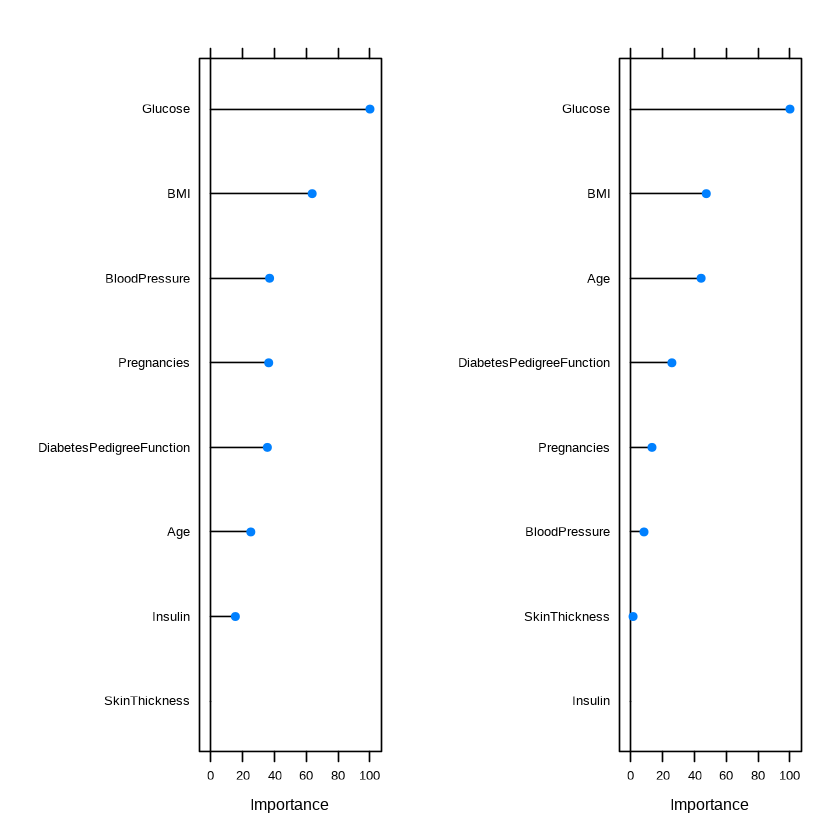

In [228]:
p1 <- plot(caret::varImp(mod1))
p2 <- plot(caret::varImp(mod2))

gridExtra::grid.arrange(grobs = list(p1, p2), nrow = 1)

- 랜덤포레스트가 더 좋은 성능

### 3-3 속도 개선을 위한 차원 축소 설명하고 수행, 예측 성능과 속도 비교하고 결과 작성

차원축소 

주성분 분석 PCA
- 상관관계가 있는 고차원 자료를 자료의 변동을 최대한 보존하는 저차원 자료 변환법
n ×  p의 차원을 줄임
- 고윳값이 높은 순으로 정렬해서, 높은 고윳값을 가진 고유 벡터만으로 데이터를 복원 누적 기여율이 85%이상이면 주성분의 수로 결정 가능
- PC loading : 주성분 계수 / PC scores : 주성분 변수

주성분 회귀
- M개의 주성분 변수를 설명 변수로
- 반응변수와 관련된 대부분의 정보는 주성분 변수에 포함됨, 그리고 M개의 주성분 계수들을 추정함으로써 과적합을 방지
- 모든 변수가 반응변수와 연관 => 주성분 회귀 효과적

In [245]:
library(regbook)

In [231]:
pca <- Smote %>% select(-Outcome)

In [232]:
pr <- princomp(pca, cor = T)

In [233]:
summary(pr)

Importance of components:
                          Comp.1    Comp.2    Comp.3    Comp.4    Comp.5
Standard deviation     1.4550280 1.2986442 0.9946179 0.9398467 0.9052353
Proportion of Variance 0.2646383 0.2108096 0.1236581 0.1104140 0.1024314
Cumulative Proportion  0.2646383 0.4754479 0.5991060 0.7095200 0.8119514
                           Comp.6     Comp.7     Comp.8
Standard deviation     0.83319602 0.65667532 0.61558990
Proportion of Variance 0.08677695 0.05390281 0.04736887
Cumulative Proportion  0.89872832 0.95263113 1.00000000

주성분 개수를 6으로 결정

In [270]:
sm.pc <- data.frame(pr$scores)

In [271]:
sm.pc <- sm.pc[, 1:6] 

In [272]:
sm.pc$Outcome <- Smote$Outcome

In [287]:
start <- Sys.time()
mod1 <- caret::train(
    Outcome ~ .,
    data = sm.pc[train, ],
    method = "glm",
    family = "binomial"
)
end <- Sys.time()
end - start

Time difference of 2.346021 secs

In [280]:
pred1 <- predict(mod1, sm.pc[test, ])
Accuracy(pred1, sm.pc[test, ]$Outcome)

[1] 0.7363344

- 로지스틱회귀 : 차원 축소후 성능 증가, 속도는 큰 변화 없음

In [288]:
start <- Sys.time()
mod2 <- caret::train(
    Outcome ~ .,
    data = sm.pc[train, ],
    method = "rf",
    preProcess = c("center", "scale"),
    trControl = trainControl(method = "cv", number = 10),
    tuneGrid = hyper_grid
)
end <- Sys.time()
end - start

Time difference of 27.10996 secs

In [283]:
pred2 <- predict(mod2, sm.pc[test,])
Accuracy(pred2, sm.pc[test, ]$Outcome)

[1] 0.7845659

- 랜덤포레스트 : 차원 축소 후 성능 감소, 속도는 향상

# 문제 4 
금속 성분 함유량 데이터(변수 1개) - 제품에 금속 재질 함유량의 분산이 1.3을 넘으면 불량이라고 보고 있는데 제조사별로 차이가 난다고 제보를 받았으며, 분산에 대해 검정을 수행하시오. (유의확률 0.05)

#### dataset : /kaggle/input/adpkrp5/content.csv

In [290]:
data2 <- read.csv("content.csv")
colSums(is.na(data2))
glimpse(data2)

content 
      0

Rows: 200
Columns: 1
$ content <dbl> 97.99529, 101.47832, 102.28491, 98.99363, 104.63523, 99.67255,~


### 4-1 연구가설과 귀무가설 작성

일표본 모분산 검정
- 귀무가설 : 분산은 1.3이다
- 대립가설 : 분산은 1.3이 아니다

### 4-2 양측 검정

In [294]:
library(TeachingDemos)

In [296]:
sigma.test(data2$content, sigma = sqrt(1.3), alternative = "two.sided")


	One sample Chi-squared test for variance

data:  data2$content
X-squared = 328.29, df = 199, p-value = 4.273e-08
alternative hypothesis: true variance is not equal to 1.3
95 percent confidence interval:
 1.778549 2.637274
sample estimates:
var of data2$content 
            2.144623 


### 4-3 검정통계량, 가설 채택

- 검정통계량 : X-squared 328.29
- P-value < 0.05 => 귀무가설 기각 => 분산은 1.3이 아니다

# 문제 5
Lot별 200개에 대한 불량 제품 수량 데이터(변수 2개 - lot번호, 불량제품수)    
/kaggle/input/adpkrp5/error.csv

In [297]:
data3 <- read.csv("error.csv")

In [299]:
colSums(is.na(data3))
glimpse(data3)

iot_number error_case_number 
                0                 0

Rows: 100
Columns: 2
$ iot_number        <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1~
$ error_case_number <dbl> 4.5, 2.5, 2.0, 3.0, 0.5, 0.5, 4.5, 4.5, 1.5, 4.5, 5.~


### 5-1 불량률 관리도에 따라 관리중심선(CL : Center Line), 관리 상한선(UCL : Upper Control Limit), 하한선(LCL : Lower Control Limit) 구하기

In [300]:
mu <- mean(data3$error_case_number)
sigma <- sd(data3$error_case_number)

In [303]:
(CL <- mu)
(UCL <- mu + 3 * sigma)
(LCL <- mu - 3 * sigma)

[1] 3.41

[1] 13.35846

[1] -6.538458

### 5-2 관리도 시각화

In [314]:
data3 <- data3 %>% mutate(CL = rep(CL, nrow(data3)),
                LCL = rep(LCL, nrow(data3)),
                UCL = rep(UCL, nrow(data3)))

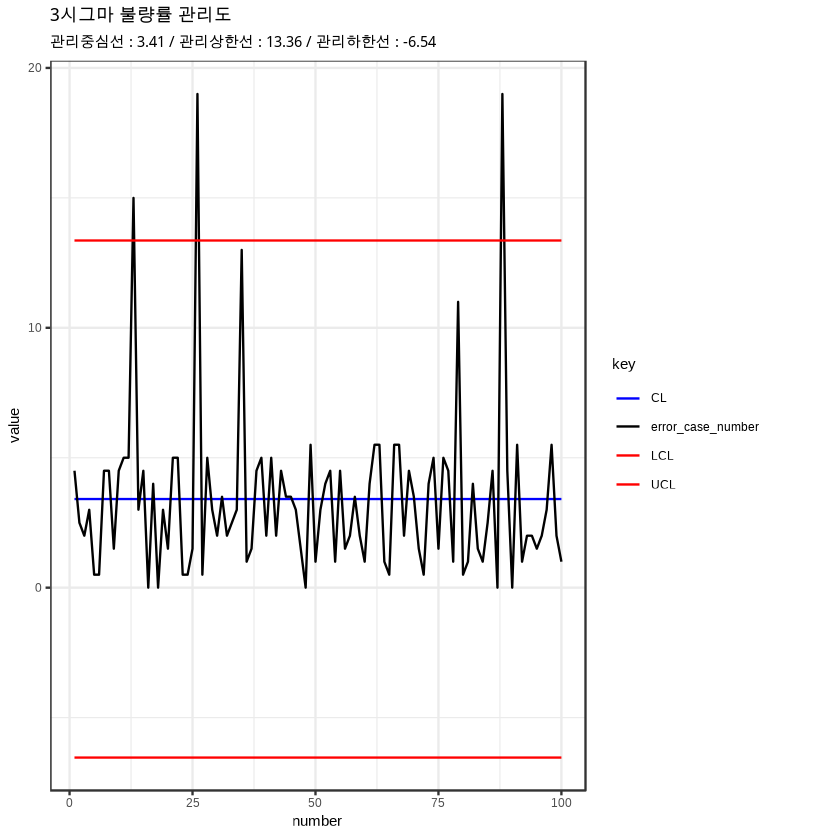

In [356]:
data3[, -1] %>% gather() %>% mutate(number = rep((1:nrow(data3)), 4)) %>% 
    ggplot(aes(number, value, colour = key)) + geom_line() + 
    scale_colour_manual(values = c("blue", "black", "red", "red")) + 
    ggtitle("3시그마 불량률 관리도", 
             subtitle = "관리중심선 : 3.41 / 관리상한선 : 13.36 / 관리하한선 : -6.54")

# 문제 6
상품 a와 b가 있을 때 다음과 같은 구매 패턴이 있다고 한다. aa bb aaaa bbbb a b aa bb aa bbb aa bb a b 구매하는 패턴으로 보아 두 상품이 연관이 있는지 확인하라

### 6-1 연구가설과 귀무가설 작성


구매패턴의 랜덤성 검정
- 귀무가설 : 연속적인 구매패턴이 임의적이다 (두 상품의 연관이 없다)
- 대립가설 : 연속적인 구매패턴이 임의적이지 않다 (두 상품의 연관이 있다)

### 6-2 평균과 표준편차

In [405]:
data <- c(0,0,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,0,0,1,1,1,0,0,1,1,0,1)

귀무가설하 통계량

- b 개수 = 15 / a 개수 = 14

In [384]:
a = 14 ; b = 15

In [388]:
mu <- ((2 * a * b) / (a + b)) + 1
var <- (2*a*b*(2*a*b - a - b)) / {(a + b)^2 * (a + b - 1)}

In [389]:
mu ; sqrt(var)

[1] 15.48276

[1] 2.640803

### 6-3 가설 채택

In [418]:
library(DescTools)

In [422]:
DescTools::RunsTest(data)


	Runs Test for Randomness

data:  data
runs = 14, m = 14, n = 15, p-value = 0.7058
alternative hypothesis: true number of runs is not equal the expected number


P-value > 0.05 => 귀무가설 기각불가 => 연속적인 구매패턴이 임의적